# XGBoost on Mean dEdX + Residual Range

Binary pion classifier using only **mean dEdX** and **mean residual range** from summary statistics.
This provides a fair comparison against the CNN which uses the full hit-level dEdX and RR profiles (also just 2 features, but the full sequence rather than the mean).

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from nn_utils import purity, efficiency, create_confusion_matrix

np.random.seed(42)

## Data Loading

Load the full summary dataset and subsample to match the CNN's 100k dataset size (~34k train / ~8.5k test). Use only `track_dEdX_mean` and `residual_range_mean`.

In [2]:
PION_LABEL = "$\\pi^{\\pm}$"
FEATURES = ["track_dEdX_mean", "residual_range_mean"]
N_TRAIN = 34123  # match CNN split
N_TEST = 8531

data = pd.read_pickle("extracted-data-summary/data_FULL_split.pkl")

# Subsample to match CNN dataset size
train_idx = np.random.choice(len(data['x_train']), size=N_TRAIN, replace=False)
test_idx = np.random.choice(len(data['x_test']), size=N_TEST, replace=False)

x_train = data['x_train'].iloc[train_idx][FEATURES].values
x_test = data['x_test'].iloc[test_idx][FEATURES].values
y_train_raw = data['y_train'].iloc[train_idx]
y_test_raw = data['y_test'].iloc[test_idx]

# Convert to binary: pion = 1, everything else = 0
y_train = (y_train_raw == PION_LABEL).astype(int).values
y_test = (y_test_raw == PION_LABEL).astype(int).values

n_pion_train = y_train.sum()
n_pion_test = y_test.sum()
print(f"Features: {FEATURES}")
print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
print(f"\nTrain: {n_pion_train} pions / {len(y_train)} total ({100*n_pion_train/len(y_train):.1f}%)")
print(f"Test:  {n_pion_test} pions / {len(y_test)} total ({100*n_pion_test/len(y_test):.1f}%)")

Features: ['track_dEdX_mean', 'residual_range_mean']
x_train: (34123, 2), x_test: (8531, 2)

Train: 6416 pions / 34123 total (18.8%)
Test:  1628 pions / 8531 total (19.1%)


## Train XGBoost

In [13]:
model = XGBClassifier(
    max_depth=10,
    learning_rate=0.2,
    n_estimators=50,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(x_train, y_train)
print(f"Model trained: {model.n_estimators} trees, max_depth={model.max_depth}")

Model trained: 50 trees, max_depth=10


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [17:27:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Evaluation

In [14]:
# Get probabilities
test_probs = model.predict_proba(x_test)[:, 1]  # probability of pion class
test_preds = model.predict(x_test)

pur_val, pur_unc = purity(test_preds, y_test, [1], [1], return_uncertainty=True)
eff_val, eff_unc = efficiency(test_preds, y_test, [1], [1], return_uncertainty=True)

print(f"=== XGBoost Results (default threshold=0.5) ===")
print(f"Pion Purity:     {100*pur_val:.1f}% \u00b1 {100*pur_unc:.1f}%")
print(f"Pion Efficiency: {100*eff_val:.1f}% \u00b1 {100*eff_unc:.1f}%")
print(f"Purity x Eff:    {100*pur_val*eff_val:.1f}%")

=== XGBoost Results (default threshold=0.5) ===
Pion Purity:     54.2% ± 2.0%
Pion Efficiency: 20.7% ± 1.0%
Purity x Eff:    11.2%


## Threshold Optimisation

Optimal threshold (max purity x efficiency): 0.10
  Purity:     26.9%
  Efficiency: 82.3%
  Product:    22.1%
  ROC AUC:    0.723


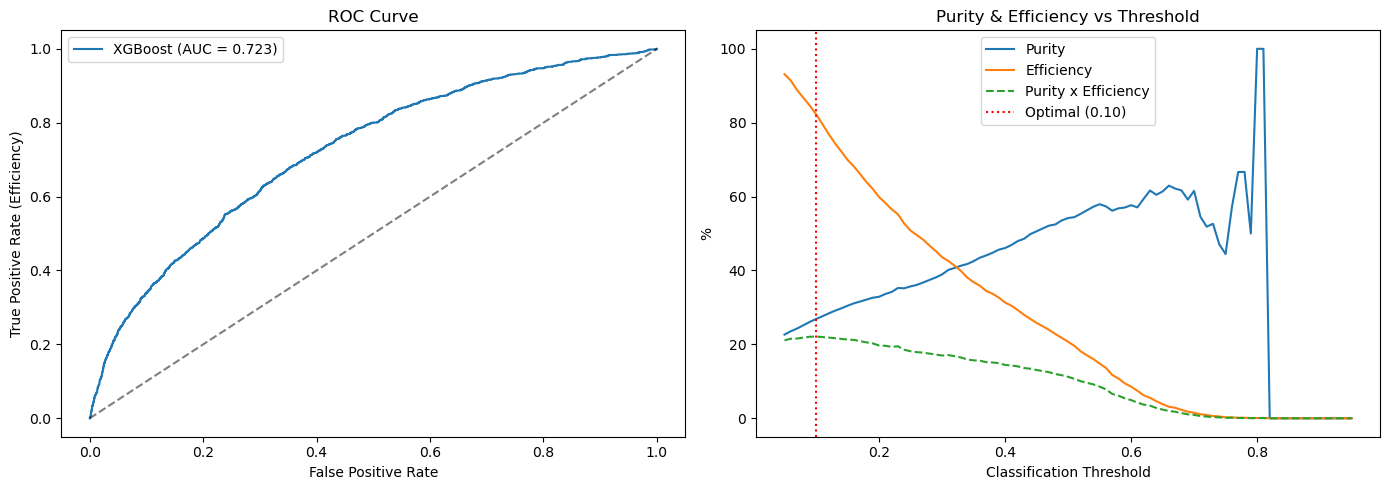

In [15]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# Threshold scan
thresholds = np.arange(0.05, 0.96, 0.01)
purities_scan = []
efficiencies_scan = []

for t in thresholds:
    preds = (test_probs >= t).astype(int)
    purities_scan.append(purity(preds, y_test, [1], [1]))
    efficiencies_scan.append(efficiency(preds, y_test, [1], [1]))

purities_scan = np.array(purities_scan)
efficiencies_scan = np.array(efficiencies_scan)
product = purities_scan * efficiencies_scan

best_idx = np.argmax(product)
best_threshold = thresholds[best_idx]

print(f"Optimal threshold (max purity x efficiency): {best_threshold:.2f}")
print(f"  Purity:     {100*purities_scan[best_idx]:.1f}%")
print(f"  Efficiency: {100*efficiencies_scan[best_idx]:.1f}%")
print(f"  Product:    {100*product[best_idx]:.1f}%")
print(f"  ROC AUC:    {roc_auc:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Efficiency)')
axes[0].set_title('ROC Curve')
axes[0].legend()

axes[1].plot(thresholds, 100*purities_scan, label='Purity')
axes[1].plot(thresholds, 100*efficiencies_scan, label='Efficiency')
axes[1].plot(thresholds, 100*product, '--', label='Purity x Efficiency')
axes[1].axvline(best_threshold, color='red', ls=':', label=f'Optimal ({best_threshold:.2f})')
axes[1].set_xlabel('Classification Threshold')
axes[1].set_ylabel('%')
axes[1].set_title('Purity & Efficiency vs Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

## Final Evaluation at Optimal Threshold

In [11]:
THRESHOLD = best_threshold
final_preds = (test_probs >= THRESHOLD).astype(int)

pur_val, pur_unc = purity(final_preds, y_test, [1], [1], return_uncertainty=True)
eff_val, eff_unc = efficiency(final_preds, y_test, [1], [1], return_uncertainty=True)

print(f"=== Final Results (threshold={THRESHOLD:.2f}) ===")
print(f"Pion Purity:     {100*pur_val:.1f}% \u00b1 {100*pur_unc:.1f}%")
print(f"Pion Efficiency: {100*eff_val:.1f}% \u00b1 {100*eff_unc:.1f}%")
print(f"Purity x Eff:    {100*pur_val*eff_val:.1f}%")
print(f"ROC AUC:         {roc_auc:.3f}")

=== Final Results (threshold=0.10) ===
Pion Purity:     26.7% ± 0.6%
Pion Efficiency: 84.3% ± 0.9%
Purity x Eff:    22.5%
ROC AUC:         0.728


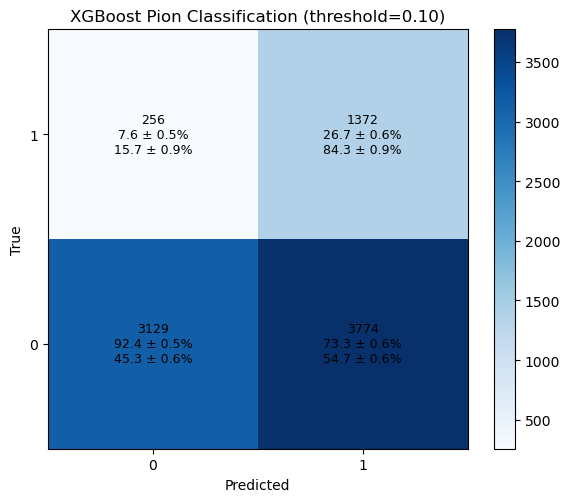

In [12]:
# Confusion matrix
cm, info, labels = create_confusion_matrix(y_test, final_preds)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, info[i][j], ha='center', va='center', fontsize=9)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels[::-1])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'XGBoost Pion Classification (threshold={THRESHOLD:.2f})')
plt.colorbar(im)
plt.tight_layout()
plt.show()

## Save Results

In [8]:
results = {
    "model_name": "XGBoost (mean dEdX + RR)",
    "probs": test_probs,
    "labels": y_test,
    "threshold": best_threshold,
    "purity": pur_val,
    "efficiency": eff_val,
    "auc": roc_auc
}

with open("results/xgb_mean_dEdX_RR.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to results/xgb_mean_dEdX_RR.pkl")
print(f"Keys: {list(results.keys())}")

Results saved to results/xgb_mean_dEdX_RR.pkl
Keys: ['model_name', 'probs', 'labels', 'threshold', 'purity', 'efficiency', 'auc']
